In [1]:
%matplotlib inline
import math
import torch

from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size = 32
num_steps = 35

train_iter, vocab = d2l.load_data_time_machine(batch_size,num_steps)

定义模型

In [5]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

#torch.nn.RNN(   input_size = input_size,
#                hidden_size = hidden_size,
#                num_layers = num_layers)


使用张量来初始化隐藏状态

In [6]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

通过一个隐藏状态和一个输入，我们就可以用更新后的隐藏状态计算输出

In [7]:
X = torch.rand(size=(num_steps,batch_size,len(vocab)))
Y, state_new = rnn_layer(X, state)

Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

我们为一个完整的循环神经网络模型定义了一个RNNModel类。 \
注意，rnn_layer只包含隐藏的循环层，我们还需要创建一个单独的输出层。

In [8]:
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)

        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size

        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            #我们需要自己构建输出层(采用一个线性层来输出)
            #输出形状是(时间步数*批量大小,词表大小)
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)

        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):

        # 对输入做转换, 转换成vocab—size大小的one-hot向量
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)

        #投入rnn运算
        Y, state = self.rnn(X, state)

        # 全连接层  
        # 首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。

        # (step*batch_size, num_hiddens) -> (step*batch_size, vocab_size)
        output = self.linear(Y.reshape((-1, Y.shape[-1])))

        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

在训练模型之前，让我们基于一个具有随机权重的模型进行预测。

In [9]:
device = d2l.try_gpu()
net = (RNNModel(rnn_layer,len(vocab))).to(device)
d2l.predict_ch8('time traveller ',10, net, vocab, device)

'time traveller szsrsrszsr'

perplexity 1.3, 242800.9 tokens/sec on cuda:0
time travellerit s again a wal of trace aling of space gon has a
travelleris would mover alline dowe than at wather sain a f


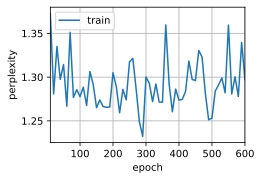

In [12]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)